## How to run the file
Paste this file on the main project director and run the code. Project file hierarchy must be as mention below

* jaya 
    * dataset (BRATS Dataset, just download dataset and extract here)
        * BRATS2015_Testing (no need of this folder)
        * BRATS2015_Training
            * HGG
            * LGG
    * Flair_Output
        * Otsu_data
        * FlairOtsuDataGeneration
    * BTD.ipynb (this file)
    
    
###### Variables
* NO_CANDIDATES (determine how many candidate)
* slice_lists (determine which slice of image)
* NO_ITERATIONS_LIST (no for iteration apply for algorithm)
* no_of_class_list (no of threshold class)
* no_of_image (no of image going to operate) start from to end 


> **_NOTE:_**  
* This code apply for BRATS2015 dataset.
* Necessary folder will auto generate

> **_Update:_** 
* confusion matrix
* inputted no of image
* 12 features extracted


In [1]:
import os
class MhaPath():
    def mhaPath():
        dir_path = "dataset/BRATS2015_Training/HGG/"
        dir= os.listdir(dir_path)
        flair_path=''
        t2_path=''
        t1_path=''
        ot_path=''
        path_list = []
        for i in dir:
            path={}
            dir_inner_path = dir_path+i
            dir_inner = os.listdir(dir_inner_path)
            for j in dir_inner:
                if 'Flair' in j:
                    dir_inner_inner_path = dir_inner_path+str('/')+j
                    dir_inner_inner = os.listdir(dir_inner_inner_path)
                    for k in dir_inner_inner:
                        if '.mha' in k:
                            flair_path = dir_inner_inner_path+str('/')+k
                if 'T1' in j and not 'T1c' in j:
                    dir_inner_inner_path = dir_inner_path+str('/')+j
                    dir_inner_inner = os.listdir(dir_inner_inner_path)
                    for k in dir_inner_inner:
                        if '.mha' in k:
                            t1_path = dir_inner_inner_path+str('/')+k        
                if 'T2' in j:
                    dir_inner_inner_path = dir_inner_path+str('/')+j
                    dir_inner_inner = os.listdir(dir_inner_inner_path)
                    for k in dir_inner_inner:
                        if '.mha' in k:
                            t2_path = dir_inner_inner_path+str('/')+k
                if 'OT' in j:
                    dir_inner_inner_path = dir_inner_path+str('/')+j
                    dir_inner_inner = os.listdir(dir_inner_inner_path)
                    for k in dir_inner_inner:
                        if '.mha' in k:
                            ot_path = dir_inner_inner_path+str('/')+k
            path['flair'] = flair_path
            path['t1'] = t1_path
            path['t2'] = t2_path
            path['ot'] = ot_path
            path_list.append(path)
        return path_list

In [2]:
import time
import glob
import random
import collections
import numpy as np
import pandas as pd
import SimpleITK as sitk
from skimage import exposure
from matplotlib import pyplot as plt
from skimage.segmentation import morphological_chan_vese, checkerboard_level_set
from sklearn.metrics import confusion_matrix
from skimage.measure import compare_mse, compare_psnr,compare_ssim
from skimage.feature import greycomatrix
from skimage.morphology import erosion, dilation, disk, opening,closing
# from mha_path import MhaPath

In [3]:
def flairOutputFile(slice_lists,NO_ITERATIONS_LIST,no_of_class_list,value,modality_Name,method):
    path = "../jaya/output/"+method+"/"+modality_Name+"Output/"+method+"Data/*.csv"
    columns = ['Slice','Iteration']
    for no_of_class in no_of_class_list:
        x = 'Th'+no_of_class
        columns.append(x)
    otsu_df = pd.DataFrame(columns = columns)
    value = value.split('.')[-2]
    lis = []
    for fname in glob.glob(path):
        df = pd.read_csv(fname)
        a = df[(df['f(x)<'+method+'>']==df['f(x)<'+method+'>'].max())].mean()
        file_name = fname.split('_')
        slices = file_name[1][5:]
        iterator = file_name[6].split('.')[0]
        th = file_name[5]
        t = []
        for i in range(int(th[1])):
            t.append(a[i+1])
            if i==int(th[1])-1:
                t.append(a[i+2])
                t.append(a[i+3])
        Dict = {"Slice":slices,"Iteration":iterator}
        for to,fo in zip(columns[2:],no_of_class_list):
            Dict[to]=t if th=='t'+fo else 'NaN'
        lis.append(Dict)
    
    ddf = pd.DataFrame(columns = columns)
    liss = []
    for i in slice_lists:
        i = int(i)
        for j in NO_ITERATIONS_LIST:
            j=int(j)
            li = [i,j]
            for k in range(len(no_of_class_list)):
                li.append('NaN')
            liss.append(li)
    
    for aa in liss:
        for bb in lis:
            if aa[0]==int(bb['Slice']) and aa[1]==int(bb['Iteration']):
                
                if bb['Th4']!='NaN':
                    aa[2]=bb['Th4']
                
    otsu_df = ddf.append(pd.DataFrame(liss,columns=ddf.columns))
  

    df3 = pd.DataFrame(otsu_df['Th4'].values.tolist(), columns=['Th4_t1','Th4_t2','Th4_t3','Th4_t4','Th4_Otsu','Th4_CPU_time'])
    asd =otsu_df.join([df3])
    asd=asd.drop(['Th4'],axis=1)
    asd = asd.set_index(['Slice','Iteration'])

    dirpath = "../jaya/output/"+method+"/"+modality_Name+"Output/final"+modality_Name+method+"DataGeneration"
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

    asd.to_csv(dirpath+"/"+modality_Name+"_{}.csv".format(value)) 

In [4]:
def preProcessing(image_array,NO_CANDIDATES,slice_lists,NO_ITERATIONS_LIST,no_of_class_list,value,modality_Name,method):
    image_array = image_array[0]
    for slice_list in slice_lists:          
        for NO_X in no_of_class_list:
            for NO_ITERATIONS in NO_ITERATIONS_LIST:
                NO_CANDIDATES=int(NO_CANDIDATES)
                NO_ITERATIONS=int(NO_ITERATIONS)
                NO_X = int(NO_X)
                slice_list =int(slice_list)
                start = time.time()            
                x_columns = [F'T{i}' for i in range(1, NO_X+1)]
                columns = [*x_columns, 'f(x)<'+method+'>']
                df = pd.DataFrame(np.array([None for i in range(NO_CANDIDATES*(NO_X+1))]).reshape(NO_CANDIDATES, NO_X+1), columns=columns)
                df.index.names = ['Candidate']
                df.index += 1
                slices = 'axial_view'
                img_array = image_array[slice_list,:,:]
                counts = collections.Counter(np.ravel(img_array))
                level_set = list(counts.keys())
                level_set.sort()
                def gen_X(NO_CANDIDATES, NO_X):
                    X = list()
                    for k in range(NO_CANDIDATES):
                        tmp_X = list()
                        for i in range(NO_X):
                            frm = 0 if not tmp_X else tmp_X[-1]+1
                            x = random.randint(frm, (len(level_set)-1) - (NO_X - i))
                            tmp_X.append(x)
                        X.append(tmp_X)
                    return X
                df[x_columns] = gen_X(NO_CANDIDATES, NO_X)
                def calculate_fx(X):
                    classes = list()
                    for indx, x in enumerate(X):
                        frm = 0 if indx == 0 else X[indx-1]+1
                        classes.append({level_set[i]: counts[level_set[i]] for i in range(frm, x+1)})
                    classes.append({level_set[i]: counts[level_set[i]] for i in range(X[-1]+1, len(level_set))})
                    W, means, variances, H, sH = list(), list(), list(), list(), list()
                    N = sum(counts.values())
                    for c in classes:
                        W.append(sum(c.values())/N)
                        H.append(-sum([(c[i]/W[-1]) * np.log(c[i]/W[-1]) for i in c.keys()]))
                        sH.append(-sum([c[i] * np.log(c[i]) for i in c.keys()]))
                        if sum(c.values()) == 0:
                            means.append(0)
                            variances.append(0)
                        else:
                            means.append(sum([k*v for k, v in c.items()])/sum(c.values()))
                            variances.append(sum([((means[-1] - k) ** 2)*v for k, v in c.items()])/sum(c.values()))
                    if method == 'otsu':
                        return pd.Series([sum([w * (v**2) for w,v in zip(W, variances)])])
                    elif method == 'kapur':
                        return pd.Series([sum([h for h in H])])
                    elif method == 'shannon':
                        return pd.Series([sum([sh for sh in sH])])
                    else:
                        print("Method not match error!!!")
                    
                df[['f(x)<'+method+'>']] = df[x_columns].apply(calculate_fx, axis=1)
                def jaya(item, x_name, randoms, X_best, X_worst):
                    result = item + randoms[x_name][0] * (X_best - abs(item)) - randoms[x_name][1] * (X_worst - abs(item))
                    if result < 0:
                        return 0
                    elif result > len(level_set) - 1:
                        return len(level_set) - 1
                    return int(result)
                def update_X(X, randoms):
                    best_candidate = df[df['f(x)<'+method+'>'] == df['f(x)<'+method+'>'].min()]
                    worst_candidate = df[df['f(x)<'+method+'>'] == df['f(x)<'+method+'>'].max()]
                    X_best = best_candidate[X.name].iloc[0]
                    X_worst = worst_candidate[X.name].iloc[0]
                    return X.apply(jaya, args=(X.name, randoms, X_best, X_worst))
                def compare_new_old(row):
                    if row['f(x)<'+method+'>_old'] < row['f(x)<'+method+'>_new']:
                        return pd.Series([row[F'{x}_old'] for x in x_columns]+[row['f(x)<'+method+'>_old']])
                    else:
                        return pd.Series([row[F'{x}_new'] for x in x_columns]+[row['f(x)<'+method+'>_new']])
                randoms = {F'T{i}': (random.random(), random.random()) for i in range(1, NO_X+1)}
                for i in range(NO_ITERATIONS):
                    new_df = df.copy()
                    new_df[x_columns] = df[x_columns].apply(update_X, args=(randoms,))
                    new_df[['f(x)<'+method+'>']] = new_df[x_columns].apply(calculate_fx, axis=1)
                    merged_df = pd.merge(df, new_df, on='Candidate', suffixes=('_old', '_new'))
                    df[df.columns] = merged_df.apply(compare_new_old, axis=1)
                    df[x_columns] = df[x_columns].astype('int')
                total_time = time.time()-start
                print("Slice : ",slice_list," t : ",NO_X," iteration : ",NO_ITERATIONS)
                df['CPU Time'] = round(total_time,2)
                df.to_csv("../jaya/output/"+method+"/"+modality_Name+"Output/"+method+"Data/{}_slice{}_{}_{}_t{}_{}.csv".format(modality_Name,slice_list,slices, method, NO_X, NO_ITERATIONS))
                 
                print(round(total_time,2))
                print("********************************************************************************************")
    flairOutputFile(slice_lists,NO_ITERATIONS_LIST,no_of_class_list,value,modality_Name, method)

In [5]:
def getImageArray(value):
    image = sitk.ReadImage(value)
    image_array = sitk.GetArrayFromImage(image)
    img = image_array
    coronal_255 = sitk.Cast(sitk.IntensityWindowing(image,
                                                    windowMinimum=int(np.ravel(image_array).min()),
                                                    windowMaximum=int(np.ravel(image_array).max()), 
                                                    outputMinimum=0,
                                                    outputMaximum=255
                                                ), sitk.sitkUInt8)
    median_filter = sitk.MedianImageFilter()
    median_filter.SetRadius((1,1,0))
    image = median_filter.Execute(coronal_255)
    img_gray = sitk.GetArrayFromImage(coronal_255)
    image_array = sitk.GetArrayFromImage(image)
    gamma_corrected = exposure.adjust_gamma(image_array, 4)
    p2, p98 = np.percentile(gamma_corrected, (0, 100), interpolation='higher')
    image_array = exposure.rescale_intensity(gamma_corrected, in_range=(p2, p98))
    return image_array, img, img_gray

In [6]:
def otImage(path,values,image_array,NO_CANDIDATES,slice_lists,NO_ITERATIONS_LIST,no_of_class_list, modality_Name, method):
    for key,value in path.items():
        if key == 'ot':
#             print("Inside:",values)
            print("Modality : ",key,"Image path : ", value)
            imageGT = sitk.ReadImage(value)
            image_arrayGTs = sitk.GetArrayFromImage(imageGT)
            evaluationFlair(image_array,image_arrayGTs,slice_lists,NO_ITERATIONS_LIST,no_of_class_list,values,modality_Name, method)

In [7]:
def readImage(paths,no_of_image,NO_CANDIDATES,slice_lists,NO_ITERATIONS_LIST,no_of_class_list, modality_Name, method):
    for path in paths[int(no_of_image[0]):int(no_of_image[1])+1]:
#         print("Path:",path)
        for key,value in path.items():
            try:
                if key == 'flair' and modality_Name == 'flair':
                    print("Modality : ",key,"Image path : ", value)
                    values=value
                    image_array = getImageArray(value)
                    preProcessing(image_array,NO_CANDIDATES,slice_lists,NO_ITERATIONS_LIST,no_of_class_list,value,modality_Name, method)
                    otImage(path,values,image_array,NO_CANDIDATES,slice_lists,NO_ITERATIONS_LIST,no_of_class_list, modality_Name, method)

                if key == 't1' and modality_Name == 't1':
                    print("Modality : ",key,"Image path : ", value)
                    values=value
                    image_array = getImageArray(value)
                    preProcessing(image_array,NO_CANDIDATES,slice_lists,NO_ITERATIONS_LIST,no_of_class_list,value,modality_Name,method)
                    otImage(path,values,image_array,NO_CANDIDATES,slice_lists,NO_ITERATIONS_LIST,no_of_class_list, modality_Name, method)


                if key == 't2' and modality_Name == 't2':
                    print("Modality : ",key,"Image path : ", value)
                    values=value
                    image_array = getImageArray(value)
                    preProcessing(image_array,NO_CANDIDATES,slice_lists,NO_ITERATIONS_LIST,no_of_class_list,value, modality_Name, method)
                    otImage(path,values,image_array,NO_CANDIDATES,slice_lists,NO_ITERATIONS_LIST,no_of_class_list, modality_Name, method)
            except:
                pass



In [8]:
def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store

In [9]:
def create_dataset(closing_image,psnr,ssim,mse,DC,target):
    glcm = greycomatrix(closing_image, [1], [0], symmetric=True, normed=False)
        
    """Start Feature extracting"""
    P=glcm
    (num_level, num_level2, num_dist, num_angle) = P.shape
    if num_level != num_level2:
        raise ValueError('num_level and num_level2 must be equal.')
    if num_dist <= 0:
        raise ValueError('num_dist must be positive.')
    if num_angle <= 0:
        raise ValueError('num_angle must be positive.')

    # normalize each GLCM
    P = P.astype(np.float64)
    glcm_sums = np.apply_over_axes(np.sum, P, axes=(0, 1))
    glcm_sums[glcm_sums == 0] = 1
#     P /= glcm_sums
    I = np.array(range(num_level)).reshape((num_level, 1, 1, 1))
    J = np.array(range(num_level)).reshape((1, num_level, 1, 1))


    diff_i = I - np.apply_over_axes(np.sum, (I * P), axes=(0, 1))[0, 0]
    diff_j = J - np.apply_over_axes(np.sum, (J * P), axes=(0, 1))[0, 0]

    std_i = np.sqrt(np.apply_over_axes(np.sum, (P * (diff_i) ** 2),
                                       axes=(0, 1))[0, 0])
    std_j = np.sqrt(np.apply_over_axes(np.sum, (P * (diff_j) ** 2),
                                       axes=(0, 1))[0, 0])




    # I, J = np.ogrid[0:num_level, 0:num_level]
    ##################Contrast
    contra = ((I - J) ** 2).reshape((num_level, num_level, 1, 1))
    contrasts = np.apply_over_axes(np.sum, (P * contra), axes=(0, 1))[0, 0]

    ##################dissimilarity
    dissimila = (np.abs(I - J)).reshape((num_level, num_level, 1, 1))
    dissimilarity= np.apply_over_axes(np.sum, (P * dissimila), axes=(0, 1))[0, 0]

    ##################homogeneity(Inverse Difference Moment)
    homogene = (1. / (1. + (I - J) ** 2)).reshape((num_level, num_level, 1, 1))
    homogeneity= np.apply_over_axes(np.sum, (P * homogene), axes=(0, 1))[0, 0]

    ##################ASM(Angular second moment)
    asm = np.apply_over_axes(np.sum, (P ** 2), axes=(0, 1))[0, 0]

    ##################energy
    energy = np.sqrt(asm)

    ##################correlation
    correlation = np.zeros((num_dist, num_angle), dtype=np.float64)
    cov = np.apply_over_axes(np.sum, (P * (diff_i * diff_j)),axes=(0, 1))[0, 0]
    # handle the special case of standard deviations near zero
    mask_0 = std_i < 1e-15
    mask_0[std_j < 1e-15] = True
    correlation[mask_0] = 1
    # handle the standard case
    mask_1 = mask_0 == False
    correlation[mask_1] = cov[mask_1] / (std_i[mask_1] * std_j[mask_1])

    ##################Coarseness
    coarseness = np.apply_over_axes(np.sum, P, axes=(0, 1))[0, 0]/2**(256+256)

    ##################mean
    mean_hist_int=(np.apply_over_axes(np.sum, P, axes=(0, 1))[0, 0])/(256*256)

    ##################variance    
    var_hist_int=(np.apply_over_axes(np.sum, (P-mean_hist_int)**2, axes=(0, 1))[0, 0])/(256*256)

    ##################standard deviation
    std_hist_int = np.sqrt(var_hist_int)

    ##################skewness
    skewness=(np.apply_over_axes(np.sum, (P-mean_hist_int)**3, axes=(0, 1))[0, 0])/(256*256)/(256*256*std_hist_int**3)

    ##################kurtosis
    kurtosis=(np.apply_over_axes(np.sum, (P-mean_hist_int)**4, axes=(0, 1))[0, 0])/(256*256)/(256*256*std_hist_int**4)

    ##################entropy
    entropy=np.apply_over_axes(np.sum, P*np.log2(P+1), axes=(0, 1))[0, 0]
       
    
    if not os.path.exists('bt_dataset_t4.csv'):
        columns = ['Image','Mean','Variance','Standard Deviation','Entropy','Skewness','Kurtosis',
                   'Contrast','Energy','ASM','Homogeneity','Dissimilarity','Correlation','Coarseness',
                  'PSNR','SSIM','MSE','DC','Target']
        df = pd.DataFrame(columns = columns)
        image=1
        di =pd.Series({"Image":"Image"+str(image),"Mean":mean_hist_int[0,0],"Variance":var_hist_int[0,0],
             "Standard Deviation":std_hist_int[0,0],"Entropy":entropy[0,0],
             "Skewness":skewness[0,0],"Kurtosis":kurtosis[0,0],
             "Contrast":contrasts[0,0],"Energy":energy[0,0],"ASM":asm[0,0],
             "Homogeneity":homogeneity[0,0],"Dissimilarity":dissimilarity[0,0],"Correlation":correlation[0,0],
             "Coarseness":coarseness[0,0],"PSNR":psnr,"SSIM":ssim,"MSE":mse,"DC":DC,"Target":target})
        df = df.append(di, ignore_index=True)
        df.to_csv("bt_dataset_t4.csv",index=False)
    else:
        df = pd.read_csv("bt_dataset_t4.csv")
        image = df.iloc[-1,:]
        image = int(image[0][5:])+1
        di =pd.Series({"Image":"Image"+str(image),"Mean":mean_hist_int[0,0],"Variance":var_hist_int[0,0],
             "Standard Deviation":std_hist_int[0,0],"Entropy":entropy[0,0],
             "Skewness":skewness[0,0],"Kurtosis":kurtosis[0,0],
             "Contrast":contrasts[0,0],"Energy":energy[0,0],"ASM":asm[0,0],
             "Homogeneity":homogeneity[0,0],"Dissimilarity":dissimilarity[0,0],"Correlation":correlation[0,0],
             "Coarseness":coarseness[0,0],"PSNR":psnr,"SSIM":ssim,"MSE":mse,"DC":DC,"Target":target})
        df = df.append(di, ignore_index=True)
        df.to_csv("bt_dataset_t4.csv",index=False)


In [10]:
def evaluationFlair(image_arrays,image_arrayGTs,slice_lists,NO_ITERATIONS_LIST,no_of_class_list,values,modality_Name, method):
    path = "../jaya/output/"+method+"/"+modality_Name+"Output/final"+modality_Name+method+"DataGeneration/*.csv"
    
    image_array = image_arrays[0].copy()
    img = image_arrays[1].copy()
    img_gray = image_arrays[2].copy()
    image_arrays = image_arrays[0].copy()
    image_arrayGT=image_arrayGTs.copy()
    valuee = values.split('.')[-2]
    for fname in glob.glob(path):
        test_df = pd.read_csv(fname)
        value = fname.split('/')[-1]
        value = (value.split('.')[-2]).split('_')[1]        
        lst=list()
        if valuee == value:
            for slice_list in slice_lists:
                slice_list = int(slice_list)
                df_slice = test_df[test_df['Slice']==slice_list]
                for ite in NO_ITERATIONS_LIST:
                    ite = int(ite)
                    df_iter = df_slice[df_slice['Iteration']==ite]
                    for thvalue in no_of_class_list:
                        bins=[]
                        thvalue = int(thvalue)
                        

                        if thvalue == 4:
                            df_th2 = df_iter[df_iter.columns[2:6]].copy()
                            a = df_th2.values
                            bins = np.array([a[0][0],a[0][1],a[0][2],a[0][3]])
                            bins = np.sort(bins)
                            inds = np.digitize(image_arrays, bins)
                            for i in range(0,240):
                                for j in range(0,240):
                                    if image_arrays[slice_list,:,:][i][j] <a[0][2]:
                                        image_array[slice_list,:,:][i][j]=0

                        selem = disk(2)
                        selem1 = disk(5)
                        opening_image = opening(image_array[slice_list,:,:], selem)
                        closing_image = closing(opening_image, selem1)
        
        
                        init_ls = checkerboard_level_set(closing_image.shape, 4)
                        evolution = []
                        callback = store_evolution_in(evolution)
                        ls = morphological_chan_vese(closing_image, 35, init_level_set=init_ls, smoothing=1,
                                                     iter_callback=callback)
                        


                        for i in range(0,240):
                            for j in range(0,240):
                                if image_arrayGT[slice_list,:,:][i][j] >0:
                                    image_arrayGT[slice_list,:,:][i][j]=1

                        if ls[5][1]==1:
                            for i in range(0,240):
                                for j in range(0,240):
                                    if ls[i][j]==0:
                                        ls[i][j]=1
                                    else:
                                        ls[i][j]=0






                        y_actual = np.ravel(image_arrayGT[slice_list,:,:])
                        y_predict = np.ravel(ls)

                        conf = confusion_matrix(y_actual, y_predict)
                        TN = conf[0,0]
                        FP = conf[0,1]
                        FN = conf[1,0]
                        TP = conf[1,1]
                        psnr = compare_psnr(y_actual, y_predict)
                        ssim = compare_ssim(y_actual, y_predict,data_range=y_predict.max() - y_predict.min())
                        mse = compare_mse(y_actual, y_predict)
                        

                        SE = TP/(TP+FN)  #sensitivity, recall, hit rate, or true positive rate (TPR)
                        SP = TN/(TN+FP)  #specificity, selectivity or true negative rate (TNR)
                        AC = (TP+TN)/(TP+TN+FP+FN)   #accuracy
                        PR = TP/(TP+FP)   #precision, positive predictive value (PPV)
                        BCR = 1/2*(SE+SP)   #balanced classification rate
                        BER = 1-BCR   #balanced error rate
                        F1 = 2*PR*SE/(PR+SE)   #F1 score
                        FNR = 1-SE   #miss rate or false negative rate (FNR)
                        FPR = 1-SP   #fall-out or false positive rate (FPR)
                        TS = TP/(TP+FP+FN)   #Threat score (TS) or Critical Success Index (CSI)
                        DC = 2*TP/(2*TP+FP+FN) #Dice Coefficient
                        
                        
                        if (TS > 0.70 and DC > 0.70):
                            
                            fig, axes = plt.subplots(2,4, figsize=(15, 8), dpi = 300)
                            ax = axes.flatten()

                            ax[0].imshow(img[slice_list,:,:])
                            ax[0].axis('off')
                            ax[0].set_title("Test Image Slice", fontsize=10)

                            ax[1].imshow(img_gray[slice_list,:,:],cmap=plt.cm.Greys_r)
                            ax[1].axis('off')
                            ax[1].set_title("Grey Scale Test Image Slice", fontsize=10)

                            ax[2].imshow(image_arrays[slice_list,:,:],cmap=plt.cm.Greys_r)
                            ax[2].axis('off')
                            ax[2].set_title("Filtered Test Image Slice", fontsize=10)


                            ax[3].imshow(inds[slice_list,:,:], cmap=plt.cm.Greys_r)
                            ax[3].axis('off')
                            ax[3].set_title("Test Image After Thresholding", fontsize=10)

                            ax[4].imshow(closing_image, cmap=plt.cm.Greys_r)
                            ax[4].set_axis_off()
                            ax[4].contour(ls, [0.5], colors='r')
                            ax[4].set_title("Morphological ACWE segmentation", fontsize=10)

                            ax[5].imshow(ls, cmap=plt.cm.Greys_r)
                            ax[5].set_axis_off()
                            contour = ax[5].contour(evolution[-1], [0.5], colors='r')
                            title = "Morphological ACWE evolution"
                            ax[5].set_title(title, fontsize=10)

                            ax[6].imshow(ls, cmap=plt.cm.Greys_r)
                            ax[6].set_axis_off()
                            # contour = ax[5].contour(evolution[-1], [0.5], colors='r')
                            title = "Segmented Tumor Image"
                            ax[6].set_title(title, fontsize=10)

                            ax[7].imshow(image_arrayGTs[slice_list,:,:], cmap=plt.cm.gray)
                            ax[7].set_axis_off()
                            title = "Active Brain Tumor Image"
                            ax[7].set_title(title, fontsize=10)

                            fig.tight_layout()
                            plt.show()
                            
                            target=1
                            if image_arrayGT[slice_list,:,:].max()==0:
                                target=0
                            
                            print("Slice : ",slice_list)
                            print("True Positive Rate : ",SE)
                            print("True Negative Rate : ",SP)
                            print("False Positive Rate : ",FPR)
                            print("False Negative Rate : ",FNR)
                            print("Balanced Classification Rate : ",BCR)
                            print("Balanced Error Rate : ",BER)
                            print("Accuracy : ",AC)
                            print("Precision : ",PR)
                            print("Threat Score : ",TS)
                            print("Dice Coefficient : ",DC)
                            print("Saving files........")
                            evaluation_list = [slice_list,thvalue,ite,TP,FP,TN,FN,SE,SP,FPR,FNR,BCR,BER,AC,PR,TS,DC]
                            lst.append(evaluation_list)
                            fig.savefig("../jaya/output/"+method+"/"+modality_Name+"Output/{}_{}_slice{}_t{}_{}_{}.png".format(method, modality_Name,slice_list,thvalue,ite,value))
                            columns = ['Slice','Threshold','Iteration','TP','FP','TN','FN','Sensitivity','Specificity','False Out','Miss Rate','Balanced Classification Rate','Balance Error Rate','Accuracy','Precision','Jaccard Index','Dice Coefficient']
                            df = pd.DataFrame(lst,columns = columns)
                            df.to_csv("../jaya/output/"+method+"/"+modality_Name+"Output/evaluationOutput_{}_{}_{}.csv".format(method,modality_Name,value))
                            create_dataset(closing_image, psnr, ssim, mse,DC, target)
                
                        else:
                            break                       
            


**********************************************************************************
**********************************************************************************
**********************************************************************************
WELCOME TO BRAIN TUMOR DETECTION AND CLASSIFICATION
    OTSU + JAYA | KAPUR + JAYA | SHANNON + JAYA

Work for 
OTSU + JAYA
KAPUR + JAYA
SHANNON + JAYA
Enter following fields...
Enter no of candidates e.g. 20: 20
Enter slices separated by comma if multiple slice e.g. 40,50,60 : 90
Enter no of iteration separated by comma if multiple iteration e.g. 500,1000 : 1000
Enter position of starting images to end position e.g. 5,10 : 0,5
Enter modality name (flair or t1 or t2) : flair
Enter method (otsu, kapur, shannon) : otsu
Modality :  flair Image path :  dataset/BRATS2015_Training/HGG/brats_2013_pat0022_1/VSD.Brain.XX.O.MR_Flair.54602/VSD.Brain.XX.O.MR_Flair.54602.mha
Slice :  90  t :  4  iteration :  1000
39.38
************************************

/home/jakesh/anaconda3/envs/tumorcnd/lib/python3.7/site-packages/skimage/measure/simple_metrics.py:127: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/home/jakesh/anaconda3/envs/tumorcnd/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in long_scalars


Modality :  flair Image path :  dataset/BRATS2015_Training/HGG/brats_2013_pat0011_1/VSD.Brain.XX.O.MR_Flair.54572/VSD.Brain.XX.O.MR_Flair.54572.mha
Slice :  90  t :  4  iteration :  1000
39.57
********************************************************************************************
[{'Slice': '90', 'Iteration': '1000', 'Th4': [11.0, 24.0, 37.0, 47.0, 42.31293567161419, 39.57]}]
['Slice', 'Iteration', 'Th4']
[[90, 1000, 'NaN']]
Modality :  ot Image path :  dataset/BRATS2015_Training/HGG/brats_2013_pat0011_1/VSD.Brain_3more.XX.O.OT.54577/VSD.Brain_3more.XX.O.OT.54577.mha


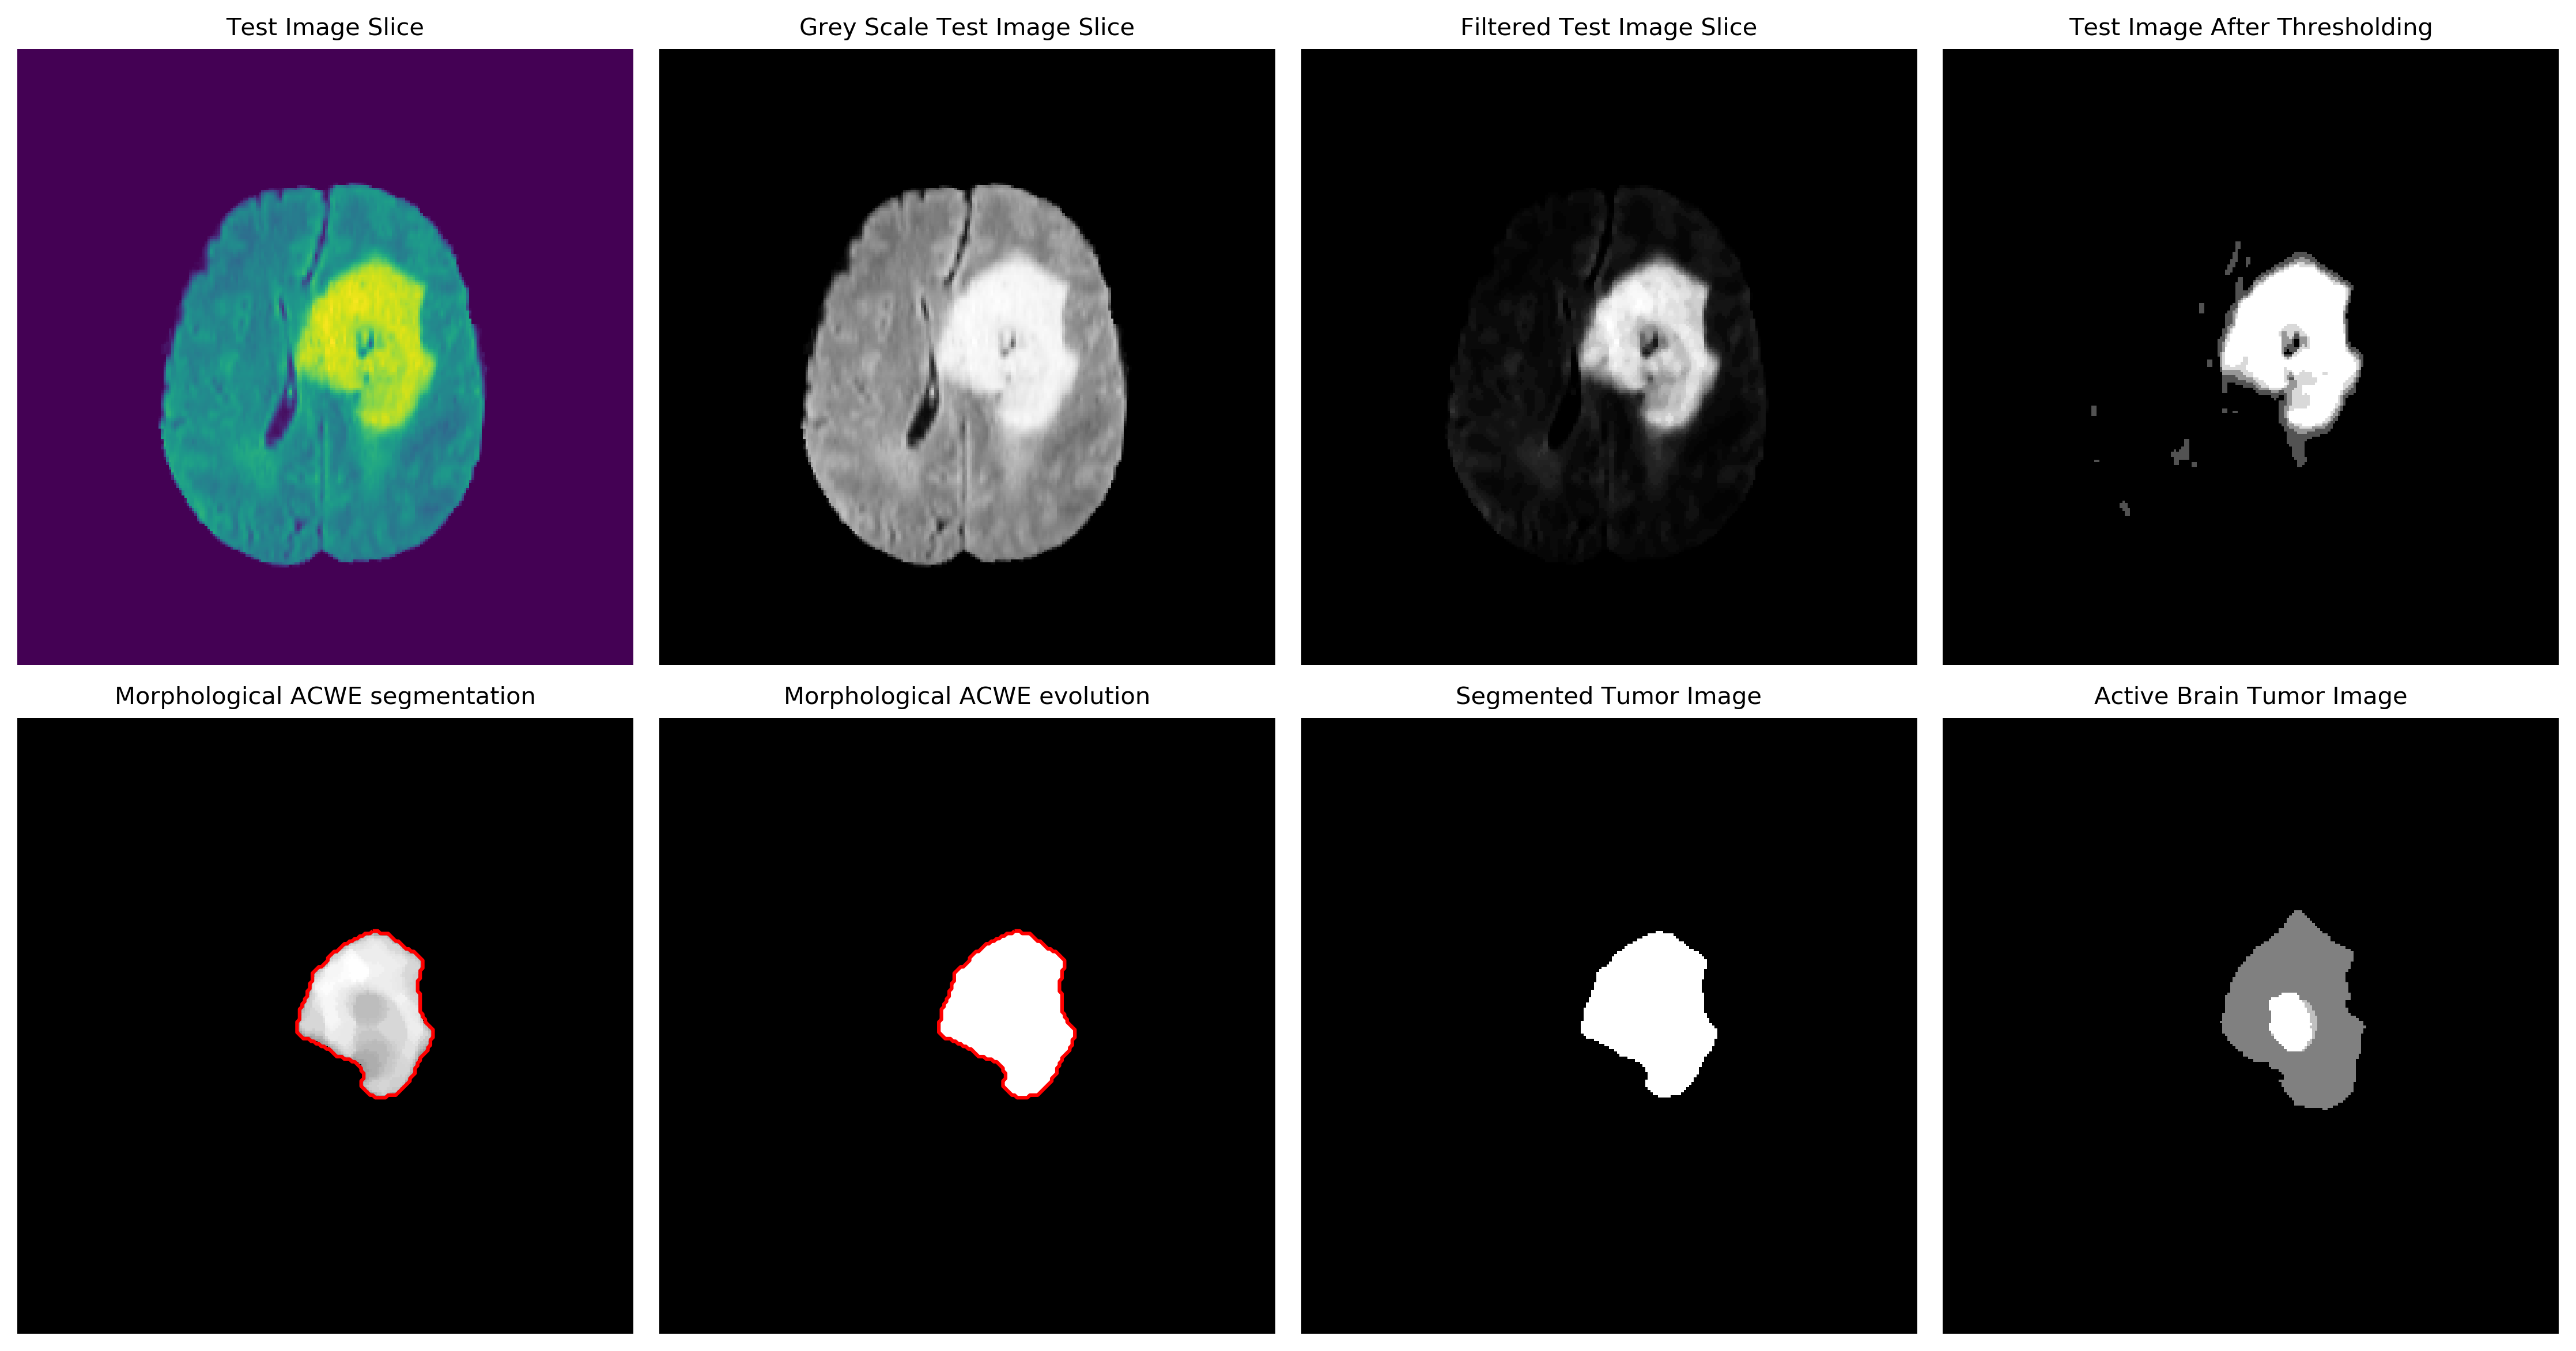

Slice :  90
True Positive Rate :  0.7945058865501249
True Negative Rate :  1.0
False Positive Rate :  0.0
False Negative Rate :  0.20549411344987512
Balanced Classification Rate :  0.8972529432750624
Balanced Error Rate :  0.10274705672493756
Accuracy :  0.99
Precision :  1.0
Threat Score :  0.7945058865501249
Dice Coefficient :  0.8854870775347913
Saving files........
Modality :  flair Image path :  dataset/BRATS2015_Training/HGG/brats_tcia_pat234_0001/VSD.Brain.XX.O.MR_Flair.35800/VSD.Brain.XX.O.MR_Flair.35800.mha


KeyboardInterrupt: 

In [11]:
directories = ['../jaya/output','../jaya/output/otsu','../jaya/output/kapur','../jaya/output/shannon',
              '../jaya/output/otsu/flairOutput','../jaya/output/otsu/t1Output','../jaya/output/otsu/t2Output',
              '../jaya/output/kapur/flairOutput','../jaya/output/kapur/t1Output','../jaya/output/kapur/t2Output',
              '../jaya/output/shannon/flairOutput','../jaya/output/shannon/t1Output','../jaya/output/shannon/t2Output',
              '../jaya/output/otsu/flairOutput/otsuData','../jaya/output/otsu/t1Output/otsuData','../jaya/output/otsu/t2Output/otsuData',
              '../jaya/output/kapur/flairOutput/kapurData','../jaya/output/kapur/t1Output/kapurData','../jaya/output/kapur/t2Output/kapurData',
              '../jaya/output/shannon/flairOutput/shannonData','../jaya/output/shannon/t1Output/shannonData','../jaya/output/shannon/t2Output/shannonData']

for dirs in directories:
    if not os.path.exists(dirs):
        os.makedirs(dirs)
        
paths = MhaPath.mhaPath()

for i in range(3):
    print("**********************************************************************************")
print("WELCOME TO BRAIN TUMOR DETECTION AND CLASSIFICATION\n    OTSU + JAYA | KAPUR + JAYA | SHANNON + JAYA\n")

print("Work for \nOTSU + JAYA\nKAPUR + JAYA\nSHANNON + JAYA\nEnter following fields...")
NO_CANDIDATES = int(input("Enter no of candidates e.g. 20: "))
slice_lists = input("Enter slices separated by comma if multiple slice e.g. 40,50,60 : ")
NO_ITERATIONS_LIST = input("Enter no of iteration separated by comma if multiple iteration e.g. 500,1000 : ")
no_of_class_list = '4'  #input("Enter no of threshold class separated by comma if multiple threshold class e.g. 2,3,4 : ")
no_of_image=input("Enter position of starting images to end position e.g. 5,10 : ")
slice_lists=slice_lists.split(',')
NO_ITERATIONS_LIST = NO_ITERATIONS_LIST.split(',')
no_of_class_list = no_of_class_list.split(',')
no_of_image = no_of_image.split(',')
modality_Name = input("Enter modality name (flair or t1 or t2) : ")
modality_Name = modality_Name.lower()
method = input("Enter method (otsu, kapur, shannon) : ")
method = method.lower()
# try:
readImage(paths,no_of_image,NO_CANDIDATES,slice_lists,NO_ITERATIONS_LIST,no_of_class_list,modality_Name,method)
# except:
#     print("Enter the reuiquired field correctly!!!")
print("_____________________________________THANK YOU VISIT AGAIN______________________________________________")